In [1]:
import seaborn as sns
import sdeint
import matplotlib.pyplot as plt
import pandas as pd
import sympy as smp
import random
import numpy as np
import pycatch22 as catch22
from sympy import real_roots
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.optimize import fsolve
import scipy
import statistics
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA, FactorAnalysis
from scipy.spatial.distance import pdist, squareform, cdist

In [2]:
random.seed(42)

Fix mu to limt cycle oscillations and fix noise to very low, observe evolution in instance space as a function of observation length N

In [312]:
def gen_hopf(mu, eta, num_samples, N): # num samples
    # hopf
    eta_val_hopf = np.tile(eta, num_samples)
    mu_val_hopf = np.tile(mu, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N+500)*dt
    tspan = np.arange(0, length, dt)
    for i in range(num_samples):
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        sols_list.append(sol[500:])
    ts_hopf = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hopf = np.array([catch22.catch22_all(ts_hopf[i,:])['values'] for i in range(len(ts_hopf))])
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = 'HopfLC'
    return ts_hopf, df_hopf

In [313]:
ts_1_50, df_1_50 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=50)
ts_1_100, df_1_100 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=100)
ts_1_500, df_1_500 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=500)
ts_1_1000, df_1_1000 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=1000)
ts_1_5000, df_1_5000 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=5000)


In [314]:
X = pd.concat([df_1_50, df_1_100, df_1_500, df_1_1000, df_1_5000], axis=0)

In [315]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
#sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
#sigmoid_transformer.fit(rs_fit)
#sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [316]:
pca = PCA(n_components=2).fit_transform(X_hat)

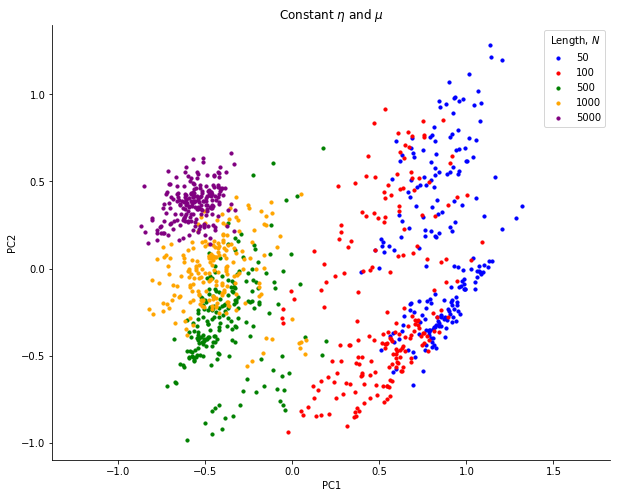

In [317]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='50', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='100', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='500', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='1000', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='5000', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $\mu$')
plt.legend().set_title("Length, $N$")  
plt.show()


Fix N and eta, vary mu

In [318]:
ts_2_mu1, df_2_mu1 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=5000)
ts_2_mu2, df_2_mu2 = gen_hopf(mu=-0.5, eta=0.001, num_samples=200, N=5000)
ts_2_mu3, df_2_mu3 = gen_hopf(mu=0, eta=0.001, num_samples=200, N=5000)
ts_2_mu4, df_2_mu4 = gen_hopf(mu=0.5, eta=0.001, num_samples=200, N=5000)
ts_2_mu5, df_2_mu5 = gen_hopf(mu=1, eta=0.001, num_samples=200, N=5000)


In [338]:
ts_2_mu6, df_2_mu6 = gen_hopf(mu=-5, eta=0.001, num_samples=200, N=5000)

In [352]:
X = pd.concat([df_2_mu1, df_2_mu2, df_2_mu3, df_2_mu4, df_2_mu5, df_2_mu6], axis=0)

In [353]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
#sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
#sigmoid_transformer.fit(rs_fit)
#sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [354]:
pca = PCA(n_components=2).fit_transform(X_hat)

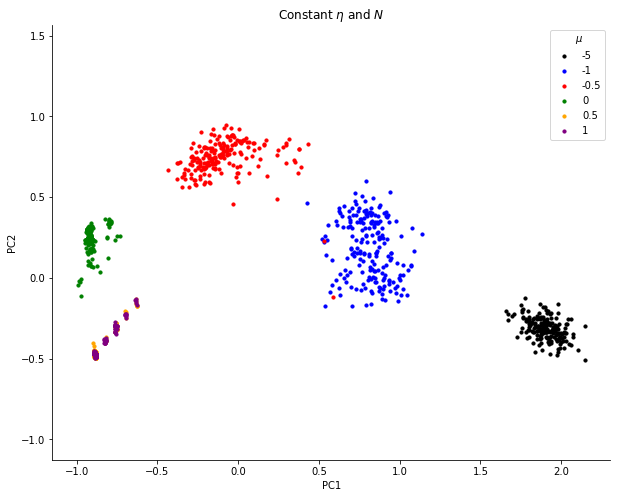

In [355]:
plt.figure(figsize=(10,8))
plt.scatter(pca[1000:1200,0], pca[1000:1200,1], label='-5', c='black',s=10)
plt.scatter(pca[:200,0], pca[:200,1], label='-1', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='-0.5', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='0', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='0.5', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='1', c='purple',s=10)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $N$')
plt.legend().set_title(" $\mu$")  
plt.show()

Fix mu and N, vary noise amplitude eta

In [379]:
ts_3_eta1, df_3_eta1 = gen_hopf(mu=-1, eta=0.001, num_samples=200, N=5000)
ts_3_eta2, df_3_eta2 = gen_hopf(mu=-1, eta=0.01, num_samples=200, N=5000)
ts_3_eta3, df_3_eta3 = gen_hopf(mu=-1, eta=0.1, num_samples=200, N=5000)
ts_3_eta4, df_3_eta4 = gen_hopf(mu=-1, eta=1, num_samples=200, N=5000)
ts_3_eta5, df_3_eta5 = gen_hopf(mu=-1, eta=2, num_samples=200, N=5000)
ts_3_eta6, df_3_eta6 = gen_hopf(mu=-1, eta=3, num_samples=200, N=5000)

In [380]:
X = pd.concat([df_3_eta1, df_3_eta2, df_3_eta3, df_3_eta4, df_3_eta5, df_3_eta6], axis=0)

In [381]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
#sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
#sigmoid_transformer.fit(rs_fit)
#sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [382]:
pca = PCA(n_components=2).fit_transform(X_hat)

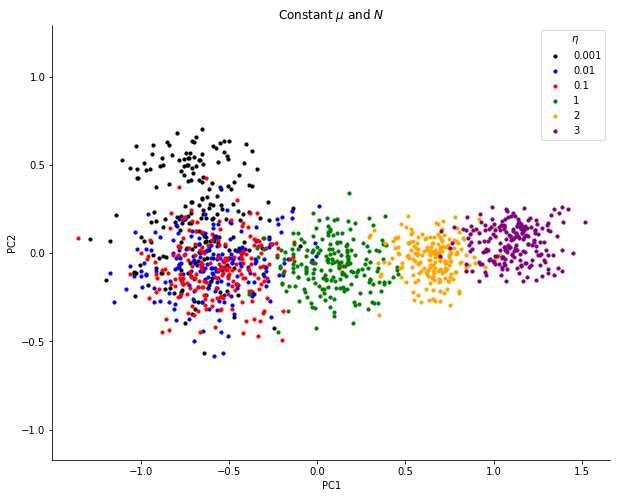

In [387]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='0.001', c='black',s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='0.01', c='blue', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='0.1', c='red', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='1', c='green', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='2', c='orange', s=10)
plt.scatter(pca[1000:1200,0], pca[1000:1200,1], label='3', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\mu$ and $N$')
plt.legend().set_title(" $\eta$")  
plt.show()


Uniform sampling over eta, mu and N according to the following ranges:
- mu = [-5, 5]
- eta = [0.001, 1]
- N = [50, 5000]

In [412]:
def gen_hopf(num_samples): # num samples
    # hopf
    eta_val_hopf = np.random.uniform(0.001, 1, num_samples)
    mu_val_hopf = np.random.uniform(-5, 5, num_samples)
    N_val_hopf = np.random.uniform(50, 5000, num_samples)
    lengths_store = list()
    regimes_store = list()
    sols_list = list()
    dt = 0.01
    for i in range(num_samples):
        length = ((N_val_hopf[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_hopf[i]
        eta = eta_val_hopf[i]
        def f(state, t):
            x, y = state[0], state[1]
            dxdt = -y + (mu - x**2 - y**2) * x
            dydt = x + (mu - x **2 - y **2) * y
            return dxdt, dydt
        ic = np.array(np.random.uniform(size=2))
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        sols_list.append(sol[500:])

        # check for regime
        if mu_val_hopf[i] < 0:
            regimes_store.append('HopfFP')
        else:
            regimes_store.append('HopfLC')

    features_hopf = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hopf = sols_list # return list of 2 dim. time series
    df_hopf = pd.DataFrame(features_hopf)
    df_hopf['N'] = lengths_store
    df_hopf['mu'] = mu_val_hopf
    df_hopf['eta'] = eta_val_hopf
    df_hopf['regime'] = regimes_store
    return ts_hopf, df_hopf

In [4]:
ts_hopf, df_hopf = gen_hopf(2000)

In [8]:
rs = RobustScaler().fit(df_hopf.iloc[:,:22])
rs_fit = rs.transform(df_hopf.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [9]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

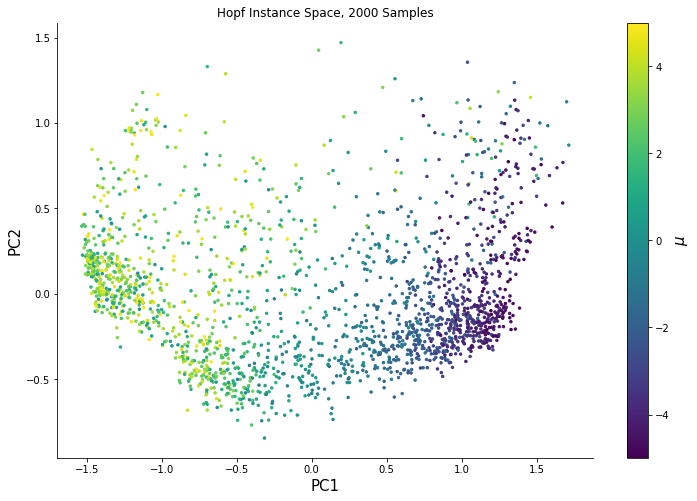

In [122]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf['mu'], s=6)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hopf Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.show()

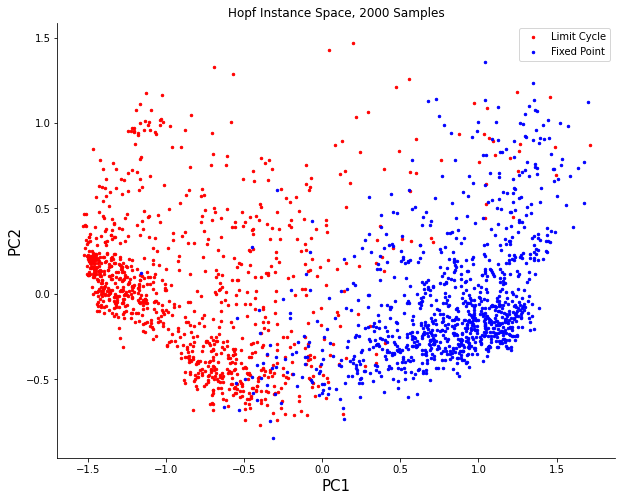

In [124]:
plt.figure(figsize=(10,8))
lc_subset = df_hopf[df_hopf['mu'] > 0].index.to_numpy()
fp_subset = df_hopf[df_hopf['mu'] < 0].index.to_numpy()
plt.scatter(pca[lc_subset,0], pca[lc_subset,1], label='Limit Cycle', c='r', s=6)
plt.scatter(pca[fp_subset,0], pca[fp_subset,1], label='Fixed Point', c='b', s=6)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hopf Instance Space, 2000 Samples')
plt.legend()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

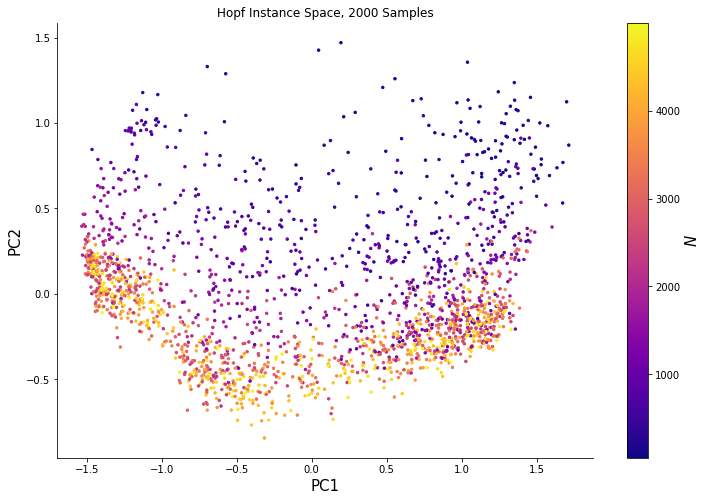

In [130]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf['N'], s=6, cmap='plasma')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hopf Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$N$', fontsize=15)
plt.show()

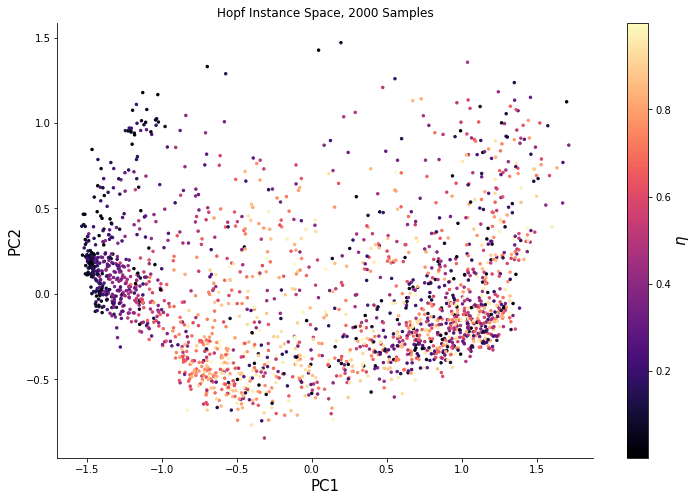

In [132]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hopf['eta'], s=6, cmap='magma')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hopf Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\eta$', fontsize=15)
plt.show()

# Hookes system

Fix mu and eta, vary N

In [190]:
def gen_hookes(num_samples, eta, mu, N):
    
    #system 1 - hookes
    n_val_hookes = np.tile(N, num_samples)
    eta_val_hookes = np.tile(eta, num_samples)
    mu_val_hookes = np.tile(mu, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N+500)*dt
    tspan = np.arange(0, length, dt)
    for i in range(num_samples):
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform(low=0, high=0.2)])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        sols_list.append(sol[500:])
    ts_hookes = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_hookes = np.array([catch22.catch22_all(ts_hookes[i,:])['values'] for i in range(len(ts_hookes))])
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = n_val_hookes
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'HookesFP'

    return ts_hookes, df_hookes

In [197]:
ts_1_50, df_1_50 = gen_hookes(200, 0.001, -1.1, 50)
ts_1_100, df_1_100 = gen_hookes(200, 0.001, -1.1, 100)
ts_1_500, df_1_500 = gen_hookes(200, 0.001, -1.1, 500)
ts_1_1000, df_1_1000 = gen_hookes(200, 0.001, -1.1, 1000)
ts_1_5000, df_1_5000 = gen_hookes(200, 0.001, -1.1, 5000)

In [198]:
X = pd.concat([df_1_50, df_1_100, df_1_500, df_1_1000, df_1_5000], axis=0)

In [199]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [200]:
pca = PCA(n_components=2).fit_transform(X_hat)

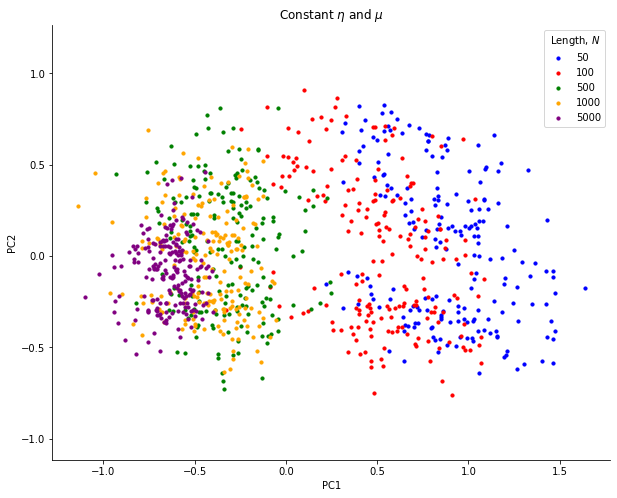

In [201]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='50', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='100', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='500', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='1000', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='5000', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $\mu$')
plt.legend().set_title("Length, $N$")  
plt.show()

In [191]:
ts_2_mu1, df_2_mu1 = gen_hookes(mu=-0.1, eta=0.001, num_samples=200, N=5000)
ts_2_mu2, df_2_mu2 = gen_hookes(mu=-0.5, eta=0.001, num_samples=200, N=5000)
ts_2_mu3, df_2_mu3 = gen_hookes(mu=-0.8, eta=0.001, num_samples=200, N=5000)
ts_2_mu4, df_2_mu4 = gen_hookes(mu=-1, eta=0.001, num_samples=200, N=5000)
ts_2_mu5, df_2_mu5 = gen_hookes(mu=-1.5, eta=0.001, num_samples=200, N=5000)

In [202]:
X = pd.concat([df_2_mu1, df_2_mu2, df_2_mu3, df_2_mu4, df_2_mu5], axis=0)

In [203]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)

In [204]:
pca = PCA(n_components=2).fit_transform(X_hat)

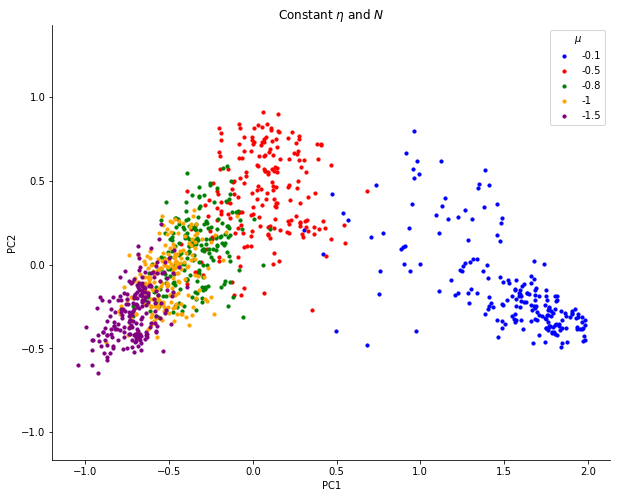

In [206]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='-0.1', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='-0.5', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='-0.8', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='-1', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='-1.5', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $N$')
plt.legend().set_title("$\mu$")  
plt.show()

In [207]:
ts_3_eta1, df_3_eta1 = gen_hookes(mu=-1.1, eta=0.0001, num_samples=200, N=5000)
ts_3_eta2, df_3_eta2 = gen_hookes(mu=-1.1, eta=0.001, num_samples=200, N=5000)
ts_3_eta3, df_3_eta3 = gen_hookes(mu=-1.1, eta=0.01, num_samples=200, N=5000)
ts_3_eta4, df_3_eta4 = gen_hookes(mu=-1.1, eta=0.1, num_samples=200, N=5000)
ts_3_eta5, df_3_eta5 = gen_hookes(mu=-1.1, eta=1, num_samples=200, N=5000)

X = pd.concat([df_3_eta1, df_3_eta2, df_3_eta3, df_3_eta4, df_3_eta5], axis=0)




In [208]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)
pca = PCA(n_components=2).fit_transform(X_hat)

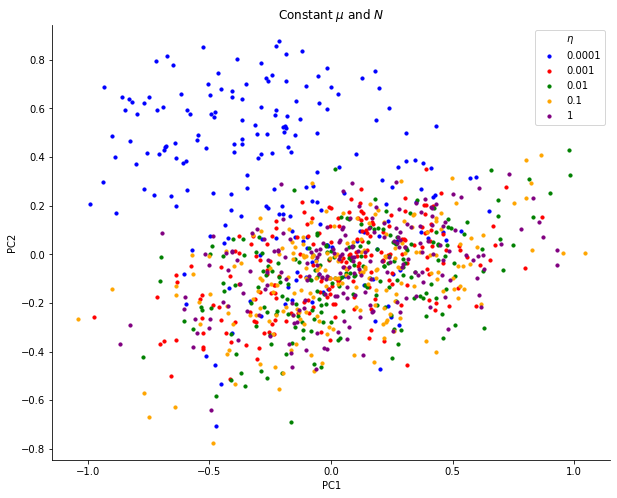

In [210]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='0.0001', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='0.001', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='0.01', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='0.1', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='1', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\mu$ and $N$')
plt.legend().set_title("$\eta$")  
plt.show()

Full instance space

In [234]:
def gen_hookes(num_samples):
    n_val_hookes = np.random.uniform(low=50, high=5000, size=num_samples)
    eta_val_hookes = np.random.uniform(low=0.001, high=1, size=num_samples)
    mu_val_hookes = np.random.uniform(low=-0.01, high=-5, size=num_samples)
    sols_list = list()
    lengths_store = list()
    dt = 0.01
    for i in range(num_samples):
        length = ((n_val_hookes[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_hookes[i]
        eta = eta_val_hookes[i]
        def f(state, t):
            x = state[0]
            dxdt = mu *x
            return dxdt
        ic = np.array([np.random.uniform(low=0, high=0.2)])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array([ic]), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        sols_list.append(sol[500:])
    features_hookes = np.array([catch22.catch22_all(sols_list[i][:,0])['values'] for i in range(len(sols_list))])
    ts_hookes = sols_list
    df_hookes = pd.DataFrame(features_hookes)
    df_hookes['N'] = lengths_store
    df_hookes['mu'] = mu_val_hookes
    df_hookes['eta'] = eta_val_hookes
    df_hookes['regime'] = 'Hookes'

    return ts_hookes, df_hookes

In [254]:
ts_hookes, df_hookes = gen_hookes(2000)

In [369]:
rs = RobustScaler().fit(df_hookes.iloc[:,:22])
rs_fit = rs.transform(df_hookes.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [370]:
pca = PCA(n_components=2).fit_transform(X_hat)

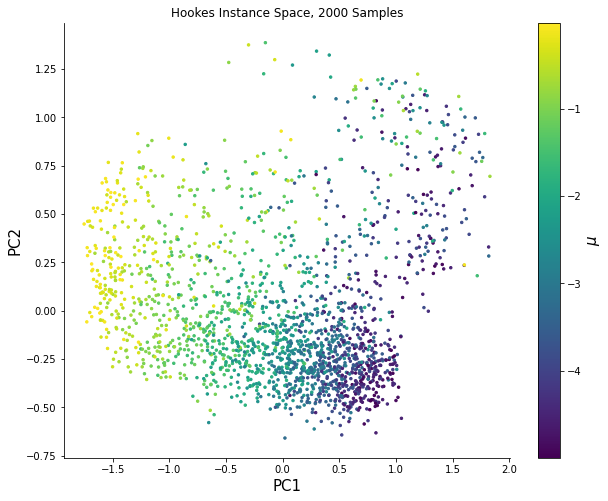

In [371]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hookes['mu'], cmap='viridis', s=6)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hookes Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.show()

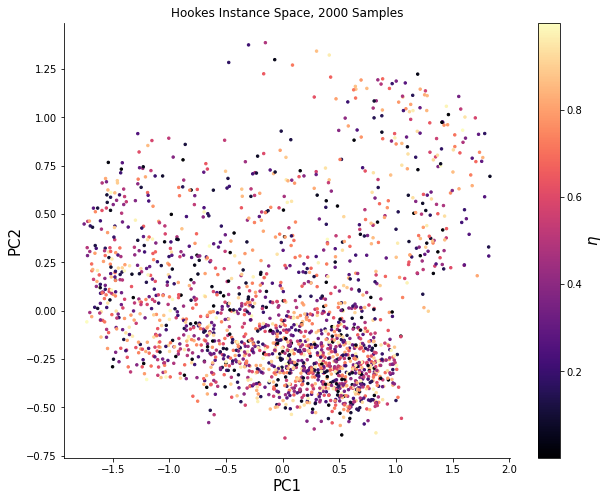

In [372]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hookes['eta'], cmap='magma', s=6)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hookes Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\eta$', fontsize=15)
plt.show()

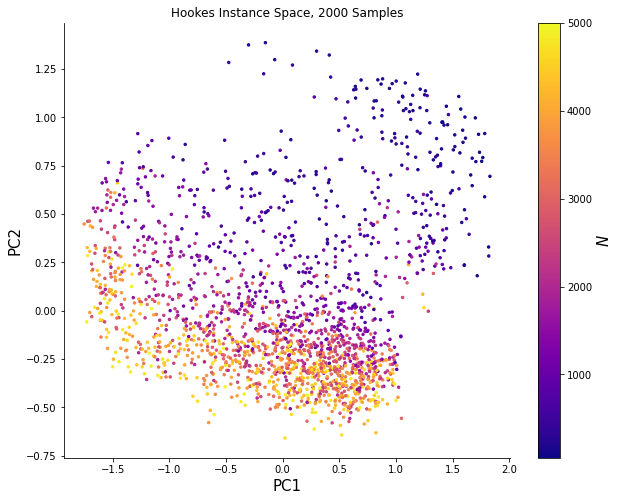

In [373]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:,0], pca[:,1], c=df_hookes['N'], cmap='plasma', s=6)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Hookes Instance Space, 2000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$N$', fontsize=15)
plt.show()

# Bistable System

In [294]:
def gen_bistable(num_samples, eta, mu, N):
    eta_val_bistable = np.tile(eta, num_samples)
    mu_val_bistable = np.tile(mu, num_samples)
    n_val_bistable = np.tile(N, num_samples)
    sols_list = list()
    dt = 0.01
    length = (N+500)*dt
    tspan = np.arange(0, length, dt)
    for i in range(num_samples):
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            print('Switching')
            # add switching label
        sols_list.append(sol[500:])
    ts_bistable = np.array([sols_list[i][:,0] for i in range(len(sols_list))])
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i,:])['values'] for i in range(len(ts_bistable))])
    df = pd.DataFrame(features_bistable)
    df['N'] = n_val_bistable
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = 'Bistable'
    return ts_bistable, df

Fix eta and mu, vary N

In [310]:
ts_1_50, df_1_50 = gen_bistable(200, 0.001, 1, 50)
ts_1_100, df_1_100 = gen_bistable(200, 0.001, 1, 100)
ts_1_500, df_1_500 = gen_bistable(200, 0.001, 1, 500)
ts_1_1000, df_1_1000 = gen_bistable(200, 0.001, 1, 1000)
ts_1_5000, df_1_5000 = gen_bistable(200, 0.001, 1, 5000)

In [311]:
X = pd.concat([df_1_50, df_1_100, df_1_500, df_1_1000, df_1_5000], axis=0)

In [312]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)
pca = PCA(n_components=2).fit_transform(X_hat)

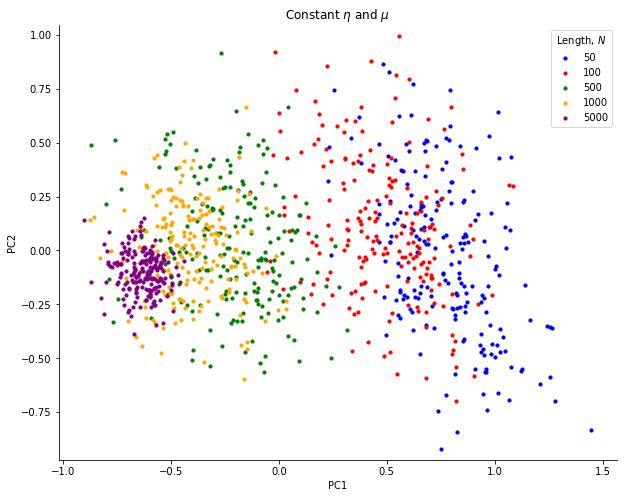

In [314]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='50', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='100', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='500', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='1000', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='5000', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $\mu$')
plt.legend().set_title("Length, $N$")  
plt.show()

Fix eta and N, vary mu

In [315]:
ts_2_mu1, df_2_mu1 = gen_bistable(200, 0.001, -1, 5000)
ts_2_mu2, df_2_mu2 = gen_bistable(200, 0.001, -0.5, 5000)
ts_2_mu3, df_2_mu3 = gen_bistable(200, 0.001, 0, 5000)
ts_2_mu4, df_2_mu4 = gen_bistable(200, 0.001, 0.5, 5000)
ts_2_mu5, df_2_mu5 = gen_bistable(200, 0.001, 1, 5000)

In [318]:
X = pd.concat([df_2_mu1, df_2_mu2, df_2_mu3, df_2_mu4, df_2_mu5], axis=0)

In [319]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)
pca = PCA(n_components=2).fit_transform(X_hat)

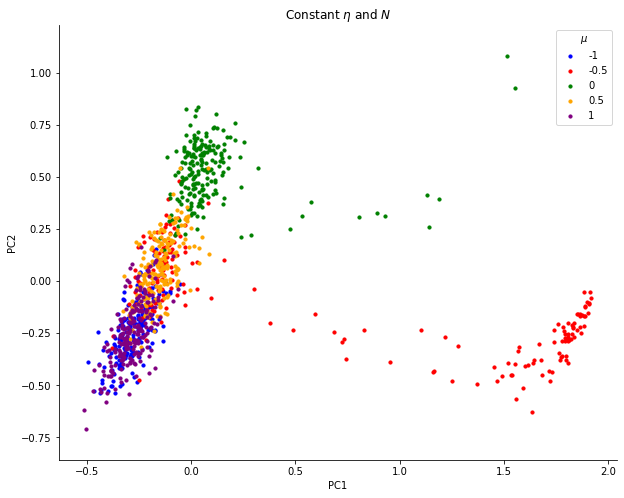

In [320]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='-1', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='-0.5', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='0', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='0.5', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='1', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\eta$ and $N$')
plt.legend().set_title("$\mu$")  
plt.show()

Fix N and mu, vary eta

In [321]:
ts_3_eta1, df_3_eta1 = gen_bistable(200, 0.0001, 1, 5000)
ts_3_eta2, df_3_eta2 = gen_bistable(200, 0.001, 1, 5000)
ts_3_eta3, df_3_eta3 = gen_bistable(200, 0.01, 1, 5000)
ts_3_eta4, df_3_eta4 = gen_bistable(200, 0.1, 1, 5000)
ts_3_eta5, df_3_eta5 = gen_bistable(200, 1, 1, 5000)

X = pd.concat([df_3_eta1, df_3_eta2, df_3_eta3, df_3_eta4, df_3_eta5], axis=0)

In [322]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
mm = MinMaxScaler().fit(rs_fit)
X_hat = mm.transform(rs_fit)
pca = PCA(n_components=2).fit_transform(X_hat)

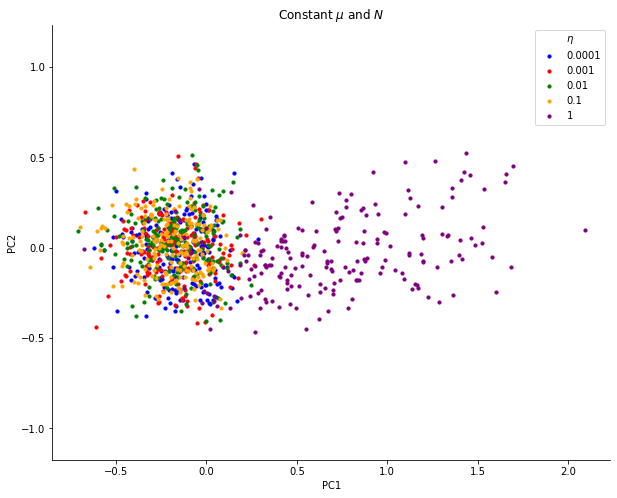

In [323]:
plt.figure(figsize=(10,8))
plt.scatter(pca[:200,0], pca[:200,1], label='0.0001', c='blue', s=10)
plt.scatter(pca[200:400,0], pca[200:400,1], label='0.001', c='red', s=10)
plt.scatter(pca[400:600,0], pca[400:600,1], label='0.01', c='green', s=10)
plt.scatter(pca[600:800,0], pca[600:800,1], label='0.1', c='orange', s=10)
plt.scatter(pca[800:1000,0], pca[800:1000,1], label='1', c='purple',s=10)


ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axis('equal')
plt.title('Constant $\mu$ and $N$')
plt.legend().set_title("$\eta$")  
plt.show()

Full instance space

In [451]:
def gen_bistable(num_samples):
    eta_val_bistable = np.random.uniform(low=0.001, high=1, size=num_samples)
    mu_val_bistable = np.random.uniform(low=-5, high=5, size=num_samples)
    n_val_bistable = np.random.uniform(low=50, high=5000, size=num_samples)
    lengths_store = list()
    switching_store = list()
    sols_list = list()
    dt = 0.01
    for i in range(num_samples):
        length = ((n_val_bistable[i]+500)*dt)
        tspan = np.arange(0, length, dt)
        mu = mu_val_bistable[i]
        eta = eta_val_bistable[i]
        def f(state, t):
            x = state
            dxdt = mu + x - x**3
            return dxdt
        ic = np.array([np.random.uniform()])
        gw = lambda y, t: eta * np.identity(ic.shape[0])
        fw = lambda y, t: np.array(f(y,t))
        sol = sdeint.itoint(fw, gw, np.array(ic), tspan)
        lengths_store.append(len(sol[500:])) # store length of time series after burn in
        X = smp.Symbol('x', real=True)
        eq = mu + X - X**3
        roots = [j.n(6) for j in real_roots(eq, X)]
        max_root = np.max(roots)
        min_root = np.min(roots)
        max_actual = np.max(sol[500:])
        min_actual = np.min(sol[500:])
        # check for switching condition
        if (len(roots) > 1) & (max_actual >= max_root) & (min_actual <= min_root):
            #print(f'Switching, instance {i}')
            switching_store.append('BistableSW')
        else:
            switching_store.append('BistableFP')
        sols_list.append(sol[500:])
    ts_bistable = sols_list
    features_bistable = np.array([catch22.catch22_all(ts_bistable[i][:,0])['values'] for i in range(len(sols_list))])
    df = pd.DataFrame(features_bistable)
    df['N'] = lengths_store
    df['mu'] = mu_val_bistable
    df['eta'] = eta_val_bistable
    df['regime'] = switching_store
    return ts_bistable, df

In [349]:
ts_bistable, df_bistable = gen_bistable(5000)

Switching, instance 48
Switching, instance 106
Switching, instance 131
Switching, instance 163
Switching, instance 223
Switching, instance 287
Switching, instance 315
Switching, instance 396
Switching, instance 403
Switching, instance 431
Switching, instance 464
Switching, instance 466
Switching, instance 487
Switching, instance 586
Switching, instance 619
Switching, instance 651
Switching, instance 732
Switching, instance 741
Switching, instance 754
Switching, instance 774
Switching, instance 777
Switching, instance 865
Switching, instance 958
Switching, instance 991
Switching, instance 1035
Switching, instance 1078
Switching, instance 1190
Switching, instance 1230
Switching, instance 1283
Switching, instance 1324
Switching, instance 1335
Switching, instance 1389
Switching, instance 1413
Switching, instance 1486
Switching, instance 1526
Switching, instance 1582
Switching, instance 1597
Switching, instance 1620
Switching, instance 1644
Switching, instance 1655
Switching, instance 1693


In [380]:
rs = RobustScaler().fit(df_bistable.iloc[:,:22])
rs_fit = rs.transform(df_bistable.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [381]:
pca = PCA(n_components=2).fit_transform(X_hat)

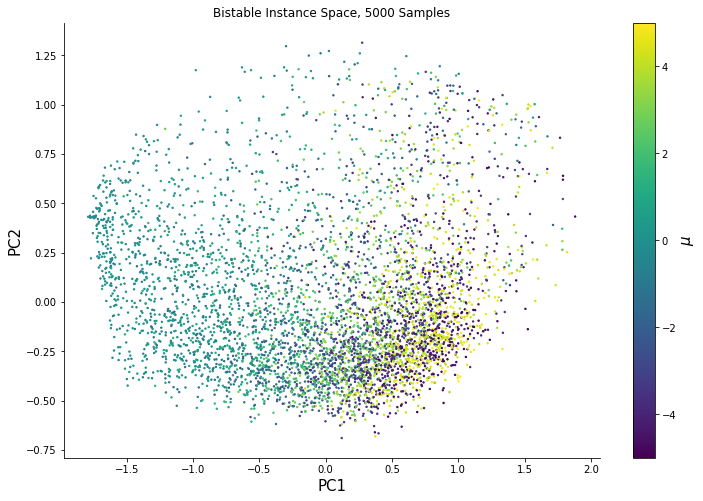

In [382]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_bistable['mu'], s=2)
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Bistable Instance Space, 5000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\mu$', fontsize=15)
plt.show()

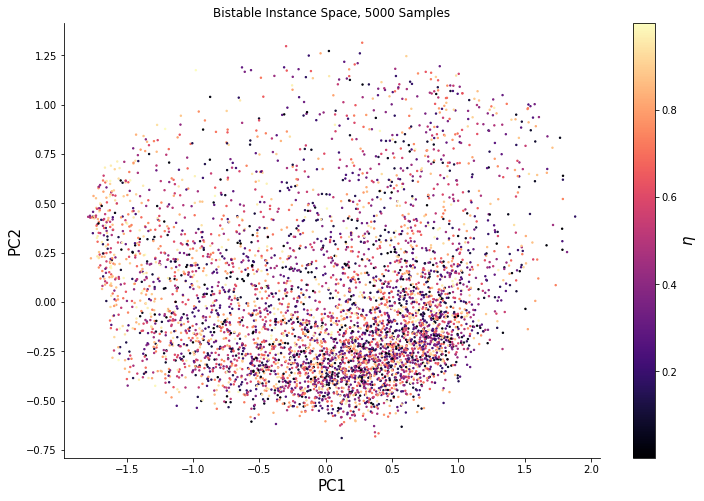

In [383]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_bistable['eta'], s=2, cmap='magma')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Bistable Instance Space, 5000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$\eta$', fontsize=15)
plt.show()

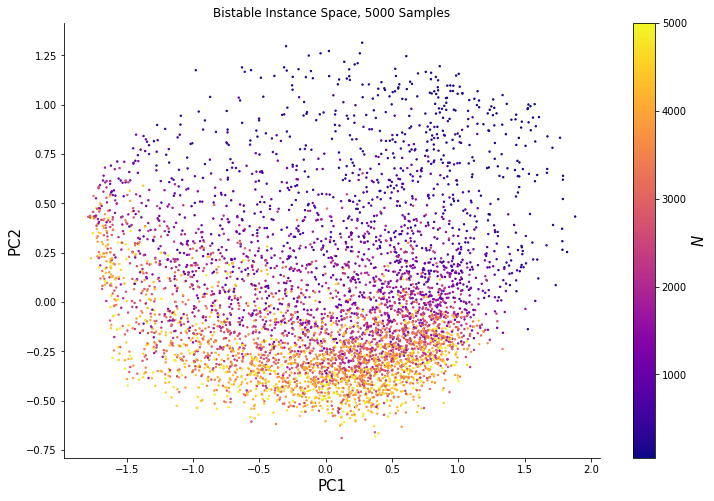

In [384]:
plt.figure(figsize=(12,8))
plt.scatter(pca[:,0], pca[:,1], c=df_bistable['N'], s=2, cmap='plasma')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Bistable Instance Space, 5000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.colorbar().set_label('$N$', fontsize=15)
plt.show()

In [385]:
switching_subset = df_bistable[df_bistable['regime'] == 'BistableSW'].index.to_numpy()
fp_subset = df_bistable[df_bistable['regime'] == 'BistableFP'].index.to_numpy()

In [410]:
print(f'{(len(switching_subset)/len(df_bistable)) *100}% instances switched')

2.68% instances switched


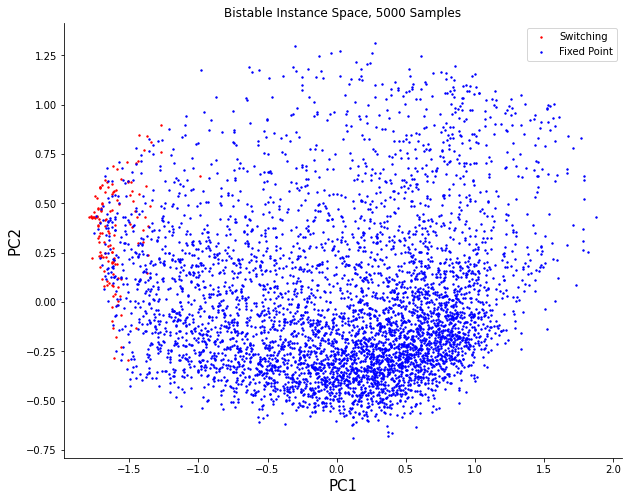

In [388]:
plt.figure(figsize=(10,8))
plt.scatter(pca[switching_subset,0], pca[switching_subset,1], c='r', s=2, label='Switching')
plt.scatter(pca[fp_subset,0], pca[fp_subset,1], c='b', s=2, label='Fixed Point')
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Bistable Instance Space, 5000 Samples')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

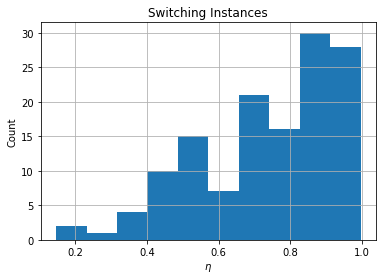

In [404]:
df_bistable[df_bistable['regime'] == 'BistableSW']['eta'].hist()
plt.xlabel('$\eta$')
plt.ylabel('Count')
plt.title('Switching Instances')
plt.show()

# Combining all three systems
Uniform sampling across eta, N and mu for each system

In [520]:
ts_bistable, df_bistable = gen_bistable(5000)
ts_hookes, df_hookes = gen_hookes(5000)
ts_hopf, df_hopf = gen_hopf(5000)

In [526]:
X = pd.concat([df_bistable, df_hookes, df_hopf], axis=0, ignore_index=True)

In [527]:
rs = RobustScaler().fit(X.iloc[:,:22])
rs_fit = rs.transform(X.iloc[:,:22])
def sigmoid(x, theta):
        return 1/(1+np.exp(-theta*x))
sigmoid_transformer = FunctionTransformer(sigmoid, kw_args={'theta': 1.35})
sigmoid_transformer.fit(rs_fit)
sigmoid_fit = sigmoid_transformer.transform(rs_fit)
mm = MinMaxScaler().fit(sigmoid_fit)
X_hat = mm.transform(sigmoid_fit)

In [528]:
pca_fit = PCA(n_components=2).fit(X_hat)
pca = pca_fit.transform(X_hat)

In [529]:
hopf_lc_subset = X[X['regime'] == 'HopfLC'].index.to_numpy()
hopf_fp_subset = X[X['regime'] == 'HopfFP'].index.to_numpy()
bistable_fp_subset = X[X['regime'] == 'BistableFP'].index.to_numpy()
bistable_sw_subset = X[X['regime'] == 'BistableSW'].index.to_numpy()
hookes_fp_subset = X[X['regime'] == 'Hookes'].index.to_numpy()

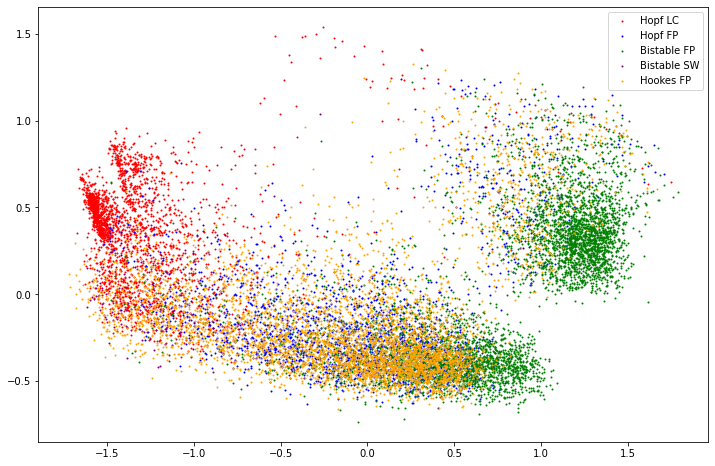

In [530]:
plt.figure(figsize=(12,8))
plt.scatter(pca[hopf_lc_subset,0], pca[hopf_lc_subset,1], c='r', s=1, label='Hopf LC')
plt.scatter(pca[hopf_fp_subset,0], pca[hopf_fp_subset,1], c='b', s=1, label='Hopf FP')
plt.scatter(pca[bistable_fp_subset,0], pca[bistable_fp_subset,1], c='g', s=1, label='Bistable FP')
plt.scatter(pca[bistable_sw_subset,0], pca[bistable_sw_subset,1], c='purple', s=1, label='Bistable SW')
plt.scatter(pca[hookes_fp_subset,0], pca[hookes_fp_subset,1], c='orange', s=1, label='Hookes FP')
plt.legend()
